# Using dynamo to perform perturbation analysis

##### Using dynamo perturbation prediction to predict TF perturbation effects

In [69]:
import numpy as np
import pandas as pd
import scanpy as sc

from sklearn.metrics import roc_auc_score
from scipy.stats import ranksums
from scvelo import logging as logg

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns

import dynamo as dyn
from dynamo.preprocessing import Preprocessor

import cellrank as cr

from rgv_tools import DATA_DIR, FIG_DIR

## Function defination

#### Functions for single knock-out

In [61]:
def p_adjust_bh(p):
    """TODO."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

def get_list_name(lst):
    """TODO."""
    names = []
    for name, obj in lst.items():
        names.append(name)
    return names

def abundance_test(prob_raw, prob_pert, correction = True):
    """TODO."""
    y = [1] * prob_raw.shape[0] + [0] * prob_pert.shape[0]
    X = pd.concat([prob_raw,prob_pert])
    
    table = []
    for i in range(prob_raw.shape[1]):
        pred = np.array(X.iloc[:,i])

        if np.sum(pred) == 0:
            pval = np.nan
            score = np.nan
        else:
            pval = ranksums(pred[np.array(y)==1],pred[np.array(y)==0])[1]
            score = roc_auc_score(y,pred)
        #result = list(scipy.stats.spearmanr(pred,y))
        result = [score,pval]
        #result[0] = np.array( (np.mean(pred[np.array(y)==1])) / (np.mean(pred[np.array(y)==0])))
        table.append(np.expand_dims(np.array(result),0))
        
    table = np.concatenate(table,0)
    table = pd.DataFrame(table)
    table.index = prob_raw.columns
    table.columns = ["coefficient","p-value"]
    ## Running FDR addjust
    table.loc[:,"FDR adjusted p-value"] = p_adjust_bh(table.loc[:,"p-value"].tolist())
    
    return table

def TFScanning_KO(adata, n_states, cluster_label, terminal_states, TF, fate_prob_return = False):
    """TODO."""
    vk = cr.kernels.VelocityKernel(adata,attr = "obsm",xkey = "X_pca", vkey = "velocity_pca")
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    g = cr.estimators.GPCCA(0.8*vk+0.2*ck)
    ## evaluate the fate prob on original space
    g.compute_macrostates(n_states=n_states, n_cells = 10,cluster_key=cluster_label)
    ## set a high number of states, and merge some of them and rename
    if terminal_states is None:
        g.predict_terminal_states()
        terminal_states = g.terminal_states.cat.categories.tolist()
    g.set_terminal_states(
        terminal_states
    )
    #g2 = g2.rename_terminal_states({"Mono_1": "Mono","DCs_1":"DC"})
    g.compute_fate_probabilities(solver="direct")
    fate_prob = g.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fate_prob.names.tolist()
    fate_prob = pd.DataFrame(fate_prob,index= sampleID,columns=fate_name)
    ## create dictionary
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1,2,3,4,5,6,7,8,9,10]:
            terminal_id.append(i+"_"+str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))
    fate_prob_original = fate_prob.copy()
    coef = []
    pvalue = []
    for tf in TF:
        ## TODO: mask using dynamo
        adata_target = adata.copy()
        dyn.pd.KO(adata_target, tf, store_vf_ko = True)
        ## perturb the regulations
        vk = cr.kernels.VelocityKernel(adata_target, attr = "obsm", xkey = "X_pca",vkey = "velocity_pca_KO")
        vk.compute_transition_matrix()
        ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
        g2 = cr.estimators.GPCCA(0.8*vk+0.2*ck)
        ## evaluate the fate prob on original space
        g2.compute_macrostates(n_states=n_states, n_cells = 10, cluster_key=cluster_label)
        ## intersection the states
        terminal_states_perturb = g2.macrostates.cat.categories.tolist()
        #terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
        terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_states))
        g2.set_terminal_states(
            terminal_states_perturb
        )
        g2.compute_fate_probabilities(solver="direct")
        fb = g2.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fb.names.tolist()
        fb = pd.DataFrame(fb,index= sampleID,columns=fate_name)
        fate_prob2 = pd.DataFrame(columns= terminal_states, index=sampleID)   
        for i in terminal_states_perturb:
            #fate_prob2.loc[:,i] = fb.loc[:,[j == i for j in terminal_states_perturb_names]].sum(1).tolist()
            fate_prob2.loc[:,i] = fb.loc[:,i]
        fate_prob2 = fate_prob2.fillna(0)
        arr = np.array(fate_prob2.sum(0))
        arr[arr!=0] = 1
        fate_prob = fate_prob * arr
        y = [0] * fate_prob.shape[0] + [1] * fate_prob2.shape[0]
        fate_prob2.index = [i + "_perturb" for i in fate_prob2.index]
        test_result = abundance_test(fate_prob, fate_prob2)
        coef.append(test_result.loc[:, "coefficient"])
        pvalue.append(test_result.loc[:, "FDR adjusted p-value"]) 
        logg.info("Done "+tf)
        fate_prob = fate_prob_original.copy()       
    d = {'TF': TF, 'coefficient': coef, 'pvalue': pvalue}
    #df = pd.DataFrame(data=d)      
    if fate_prob_return:
        return fate_prob,fate_prob2
    else:
        return d

def pipeline(adata,gene_for_KO):
    """TODO."""
    dyn.pd.perturbation(adata, gene_for_KO, [-1000], emb_basis="umap")
    effect = np.diag(adata.layers["j_delta_x_perturbation"].toarray().dot(adata.layers["velocity_S"].toarray().T))
    effect = effect / np.max(np.abs(effect))
    adata.obs["effect"] = effect
    Pigment_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "Pigment"])
    mNC_hox34_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_hox34"])
    mNC_arch2_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_arch2"])
    mNC_head_mesenchymal_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_head_mesenchymal"])
    score = [Pigment_score,mNC_hox34_score,mNC_arch2_score,mNC_head_mesenchymal_score]
    celltype = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
    df = pd.DataFrame({"PS_score": score,
                       "celltype":celltype})
    df["KO"] = gene_for_KO
    df.index = celltype
    return df

def TFScanning_perturbation(adata, n_states, cluster_label, terminal_states, TF):
    """TODO."""
    coef = []
    for tf in TF:
        ## TODO: mask using dynamo
        ## each time knock-out a TF
        df = pipeline(adata,tf)
        coef.append(df.loc[:, "PS_score"])
        logg.info("Done "+tf)
    d = {'TF': TF, 'coefficient': coef}
    #df = pd.DataFrame(data=d)      
    return d

#### Function for multiple knock-out

In [62]:
## perform multiple knock-out simulation benchmark
def split_elements(character_list):
    """TODO."""
    result_list = []
    for element in character_list:
        if '_' in element:
            parts = element.split('_')
            result_list.append(parts)
        else:
            result_list.append([element])
    return result_list

def combine_elements(split_list):
    """TODO."""
    result_list = []
    for parts in split_list:
        combined_element = "_".join(parts)
        result_list.append(combined_element)
    return result_list


def Multiple_TFScanning_KO(adata, n_states, cluster_label, terminal_states, TF_pair):
    """TODO."""
    vk = cr.kernels.VelocityKernel(adata,attr = "obsm",xkey = "X_pca", vkey = "velocity_pca")
    vk.compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
    g = cr.estimators.GPCCA(0.8*vk+0.2*ck)
    ## evaluate the fate prob on original space
    g.compute_macrostates(n_states=n_states, n_cells = 10,cluster_key=cluster_label)
    ## set a high number of states, and merge some of them and rename
    if terminal_states is None:
        g.predict_terminal_states()
        terminal_states = g.terminal_states.cat.categories.tolist()
    g.set_terminal_states(
        terminal_states
    )
    g.compute_fate_probabilities(solver="direct")
    fate_prob = g.fate_probabilities
    sampleID = adata.obs.index.tolist()
    fate_name = fate_prob.names.tolist()
    fate_prob = pd.DataFrame(fate_prob,index= sampleID,columns=fate_name)
    ## create dictionary
    terminal_id = terminal_states.copy()
    terminal_type = terminal_states.copy()
    for i in terminal_states:
        for j in [1,2,3,4,5,6,7,8,9,10]:
            terminal_id.append(i+"_"+str(j))
            terminal_type.append(i)
    terminal_dict = dict(zip(terminal_id, terminal_type))
    fate_prob_original = fate_prob.copy()
    
    coef = []
    pvalue = []
    for tf_pair in TF_pair:
        adata_target = adata.copy()
        dyn.pd.KO(adata_target, tf_pair,store_vf_ko = True)
        
        vk = cr.kernels.VelocityKernel(adata_target, attr = "obsm",xkey = "X_pca",vkey = "velocity_pca_KO")
        vk.compute_transition_matrix()
        ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
        g2 = cr.estimators.GPCCA(0.8*vk+0.2*ck)
        ## evaluate the fate prob on original space
        g2.compute_macrostates(n_states=n_states, n_cells = 10, cluster_key=cluster_label)
        ## intersection the states

        terminal_states_perturb = g2.macrostates.cat.categories.tolist()
        #terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_id))
        terminal_states_perturb = list(set(terminal_states_perturb).intersection(terminal_states))
        
        g2.set_terminal_states(
            terminal_states_perturb
        )
        g2.compute_fate_probabilities(solver="direct")
        fb = g2.fate_probabilities
        sampleID = adata.obs.index.tolist()
        fate_name = fb.names.tolist()
        fb = pd.DataFrame(fb,index= sampleID,columns=fate_name)
        fate_prob2 = pd.DataFrame(columns= terminal_states, index=sampleID)   
        
        for i in terminal_states_perturb:
            #fate_prob2.loc[:,i] = fb.loc[:,[j == i for j in terminal_states_perturb_names]].sum(1).tolist()
            fate_prob2.loc[:,i] = fb.loc[:,i]

        fate_prob2 = fate_prob2.fillna(0)
        arr = np.array(fate_prob2.sum(0))
        arr[arr!=0] = 1
        fate_prob = fate_prob * arr
        
        y = [0] * fate_prob.shape[0] + [1] * fate_prob2.shape[0]
        fate_prob2.index = [i + "_perturb" for i in fate_prob2.index]
        test_result = abundance_test(fate_prob, fate_prob2)
        coef.append(test_result.loc[:, "coefficient"])
        pvalue.append(test_result.loc[:, "FDR adjusted p-value"]) 
        print(tf_pair)
        logg.info("Done "+combine_elements([tf_pair])[0])
        fate_prob = fate_prob_original.copy()
    d = {'TF': combine_elements(TF_pair), 'coefficient': coef, 'pvalue': pvalue}
    #df = pd.DataFrame(data=d)      
    return d

def pipeline_double(adata,gene_for_KO):
    """TODO."""
    dyn.pd.perturbation(adata, gene_for_KO, [-1000]*len(gene_for_KO), emb_basis="umap")
    effect = np.diag(adata.layers["j_delta_x_perturbation"].toarray().dot(adata.layers["velocity_S"].toarray().T))
    effect = effect / np.max(np.abs(effect))
    adata.obs["effect"] = effect

    Pigment_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "Pigment"])
    mNC_hox34_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_hox34"])
    mNC_arch2_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_arch2"])
    mNC_head_mesenchymal_score = np.mean(adata.obs["effect"][adata.obs["cell_type"] == "mNC_head_mesenchymal"])

    score = [Pigment_score,mNC_hox34_score,mNC_arch2_score,mNC_head_mesenchymal_score]
    celltype = ["Pigment","mNC_hox34","mNC_arch2","mNC_head_mesenchymal"]
    df = pd.DataFrame({"PS_score": score,
                       "celltype":celltype})
    df["KO"] = combine_elements([gene_for_KO])[0]
    df.index = celltype
    
    return df

def Multiple_TFScanning_perturbation(adata, n_states, cluster_label, terminal_states, TF_pair):
    """TODO."""
    coef = []
    for tf in TF_pair:
        ## TODO: mask using dynamo
        ## each time knock-out a TF
        df = pipeline_double(adata,tf)
        coef.append(df.loc[:, "PS_score"])
        logg.info("Done "+combine_elements([tf])[0])
    d = {'TF': combine_elements(TF_pair), 'coefficient': coef}
    #df = pd.DataFrame(data=d)      
    return d

## Constants

In [22]:
DATASET = "zebrafish"

In [47]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Data Loading

In [24]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

In [25]:
adata.X = adata.layers["matrix"].copy()

In [26]:
genes = ["nr2f5","sox9b","twist1b","ets1"]

## Processing by dynamo

In [27]:
preprocessor = Preprocessor()
preprocessor.preprocess_adata(adata, recipe="monocle")

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 0 outlier cells
|-----------> filtered out 18 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [1.7923s]


In [28]:
dyn.tl.dynamics(adata)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----? layer X_velocity is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_variance_velocity is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Mu is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Ms is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Mu is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, ski

estimating gamma: 100%|██████████| 962/962 [00:06<00:00, 151.34it/s]


AnnData object with n_obs × n_vars = 697 × 962
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'stage', 'cell_type2', 'macrostates', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Ms_Size_Factor', 'initial_Ms_cell_size', 'Mu_Size_Factor', 'initial_Mu_cell_size', 'velocity_Size_Factor', 'initial_velocity_cell_size', 'variance_velocity_Size_Factor', 'initial_variance_velocity_cell_size', 'ntr'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'is_tf', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'TF', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S

In [29]:
dyn.tl.reduceDimension(adata)

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [UMAP] completed [0.0014s]


In [30]:
dyn.tl.cell_velocities(adata, basis='pca')

|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.6099s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2962s]


AnnData object with n_obs × n_vars = 697 × 962
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'stage', 'cell_type2', 'macrostates', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Ms_Size_Factor', 'initial_Ms_cell_size', 'Mu_Size_Factor', 'initial_Mu_cell_size', 'velocity_Size_Factor', 'initial_velocity_cell_size', 'variance_velocity_Size_Factor', 'initial_variance_velocity_cell_size', 'ntr'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'is_tf', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'TF', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S

In [31]:
dyn.vf.VectorField(adata,basis = "pca")

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.3344s]
|-----> [VectorField] completed [0.4372s]


In [32]:
adata_perturb = adata.copy()

In [33]:
del adata.uns["cell_type_colors"]

## Compare predict fate probability changes

In [41]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]

fate_prob = {}
fate_prob_perturb = {}

for g in genes:
    fb,fb_perturb = TFScanning_KO(adata,8,"cell_type",terminal_states,[g],fate_prob_return=True)
    fate_prob[g] = fb 
    fate_prob_perturb[g] = fb_perturb

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

|-----> In silico knockout nr2f5
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3247s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2925s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done nr2f5


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

|-----> In silico knockout sox9b
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2388s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1893s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done sox9b


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

|-----> In silico knockout twist1b
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3433s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3531s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done twist1b


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

|-----> In silico knockout ets1
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2399s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1734s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done ets1


## Visualize dynamo perturbation effects

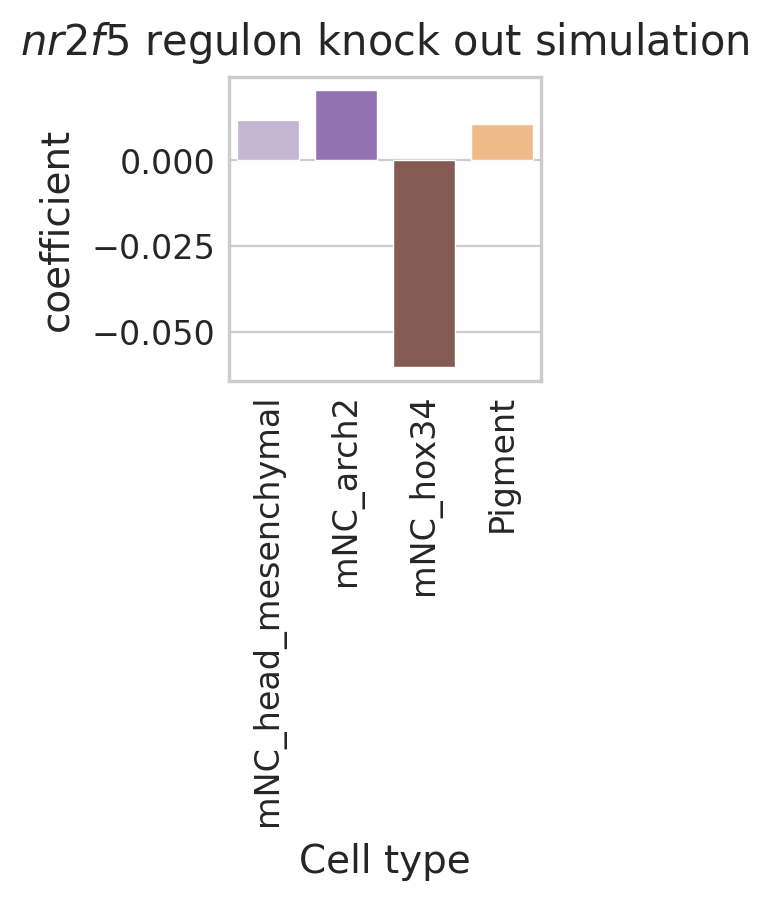

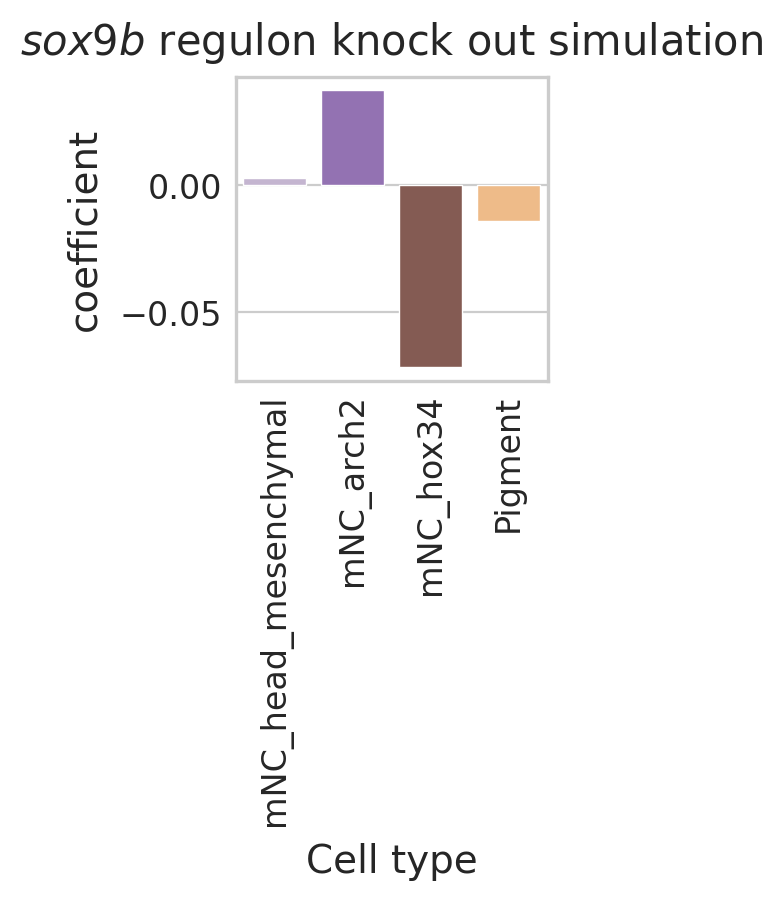

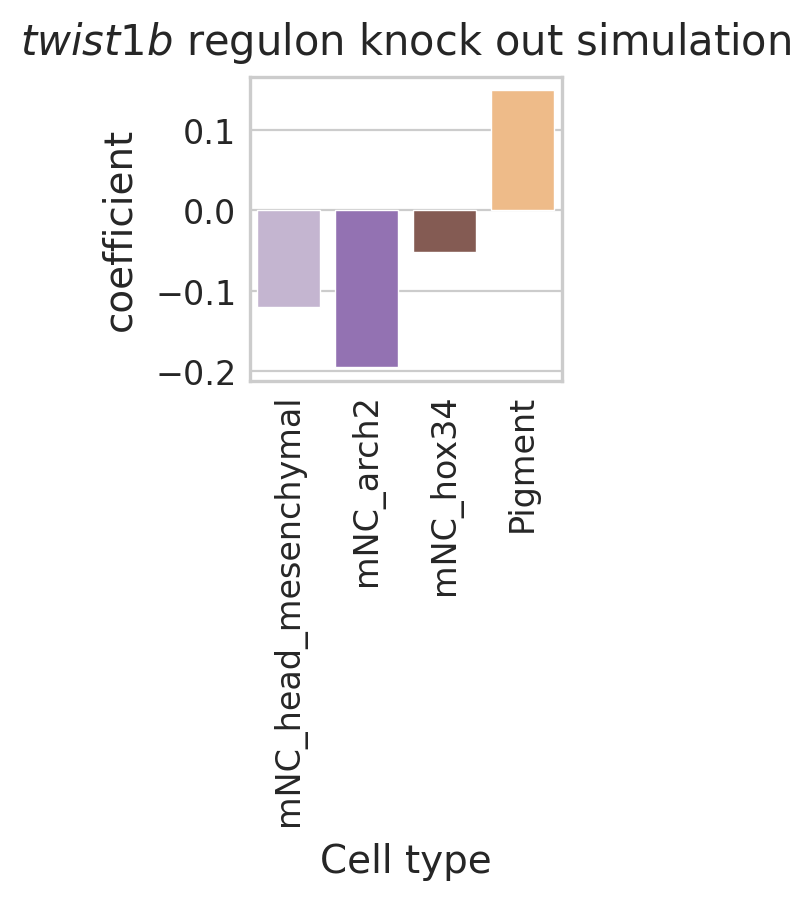

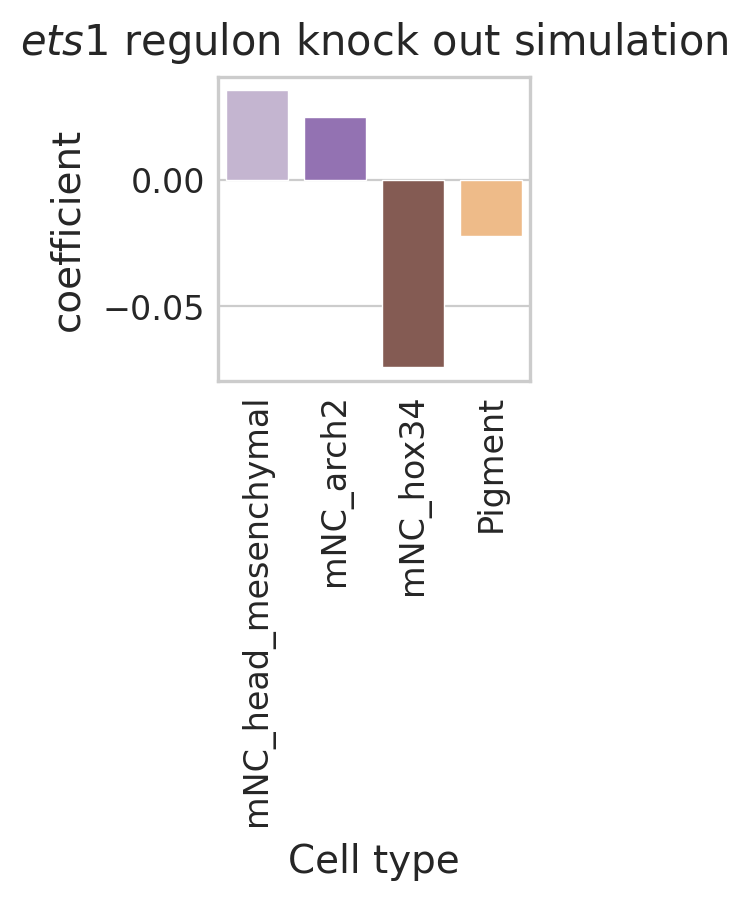

In [48]:
for g in genes:
    data = abundance_test(fate_prob[g],fate_prob_perturb[g])
    data = pd.DataFrame({"Score": data.iloc[:,0].tolist(),
                     "p-value": data.iloc[:,1].tolist(),
                     "Terminal state": data.index.tolist(),
                     "TF":[g]*(data.shape[0])})
    
    final_df = data.copy()
    final_df["Score"] = 0.5 - final_df["Score"]
    
    color_label = "cell_type"
    df = pd.DataFrame(final_df["Score"])
    df.columns = ["coefficient"]
    df["Cell type"] = final_df["Terminal state"]
    order = df["Cell type"].tolist()

    palette = dict(zip(adata.obs[color_label].cat.categories, adata_perturb.uns[f"{color_label}_colors"]))
    subset_palette = {name: color for name, color in palette.items() if name in terminal_states}

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(2,2))
        sns.barplot(
            data=df,
            y="coefficient",
            x="Cell type",
            palette=subset_palette,
            order=order,
            ax=ax,

        )
        ax.tick_params(axis='x', rotation=90)
        plt.title("$\mathit{" + g + "}$ regulon knock out simulation")

        if SAVE_FIGURES:
            plt.savefig(
                    FIG_DIR / DATASET / f"{g}_perturbation_simulation_dynamo.svg",
                    format="svg",
                    transparent=True,
                    bbox_inches='tight'
                )
        # Show the plot
        plt.show()

## Perturbation benchmark

In [51]:
gene_list = ['elk3',
 'erf',
 'etv2',
 'fli1a',
 'mitfa',
 'nr2f5',
 'rarga',
 'rxraa',
 'smarcc1a',
 'tfec',
 'nr2f2']

In [52]:
gene_list = set(gene_list).intersection(adata.var_names)
gene_list = list(gene_list)

In [53]:
## Dynamo (KO)
d = TFScanning_KO(adata,8,"cell_type",terminal_states,gene_list)

## Dynamo (perturbation)
d2 = TFScanning_perturbation(adata,8,"cell_type",terminal_states,gene_list)

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

|-----> In silico knockout rarga
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2551s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2240s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done rarga
|-----> In silico knockout erf
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2857s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2843s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done erf
|-----> In silico knockout nr2f2
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3279s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.3764s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done nr2f2
|-----> In silico knockout fli1a
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2482s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2689s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done fli1a
|-----> In silico knockout elk3
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3563s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2665s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done elk3
|-----> In silico knockout tfec
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2412s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2287s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done tfec
|-----> In silico knockout rxraa
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2166s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1771s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done rxraa
|-----> In silico knockout nr2f5
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2009s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1860s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done nr2f5
|-----> In silico knockout mitfa
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2722s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2845s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

Done mitfa
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....


calculating Jacobian for each cell: 100%|██████████| 697/697 [00:00<00:00, 147424.60it/s]

|-----> project the pca perturbation vector to low dimensional space....


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1811s]
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
Done rarga
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1964s]
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
Done erf
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X

In [63]:
## Perform KO screening using function based perturbation
coef_KO = pd.DataFrame(np.array(d['coefficient']))
coef_KO.index = d['TF']
coef_KO.columns = get_list_name(d['coefficient'][0])

## Perform perturbation screening using gene expression based perturbation
coef_perturb = pd.DataFrame(np.array(d2['coefficient']))
coef_perturb.index = d2['TF']
coef_perturb.columns = get_list_name(d2['coefficient'][0])

## Multiple gene knock-out prediction

In [64]:
multiple_ko = ["fli1a_elk3","mitfa_tfec","tfec_mitfa_bhlhe40","fli1a_erf_erfl3","erf_erfl3"]
multiple_ko_list = split_elements(multiple_ko)

In [66]:
## Dynamo (KO)
d = Multiple_TFScanning_KO(adata,9,"cell_type",terminal_states,multiple_ko_list)

## Dynamo (perturbation)
d2 = Multiple_TFScanning_perturbation(adata,9,"cell_type",terminal_states,multiple_ko_list)

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

|-----> In silico knockout ['fli1a', 'elk3']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2267s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1812s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

['fli1a', 'elk3']
Done fli1a_elk3
|-----> In silico knockout ['mitfa', 'tfec']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2364s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1918s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

['mitfa', 'tfec']
Done mitfa_tfec
|-----> In silico knockout ['tfec', 'mitfa', 'bhlhe40']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2129s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1882s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

['tfec', 'mitfa', 'bhlhe40']
Done tfec_mitfa_bhlhe40
|-----> In silico knockout ['fli1a', 'erf', 'erfl3']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.2503s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1883s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

['fli1a', 'erf', 'erfl3']
Done fli1a_erf_erfl3
|-----> In silico knockout ['erf', 'erfl3']
|-----> Project the high dimensional vector field after KO to umap.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3352s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2969s]


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/4 [00:00<?, ?/s]

['erf', 'erfl3']
Done erf_erfl3
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1931s]
|-----> you can use dyn.pl.streamline_plot(adata, basis='umap_perturbation') to visualize the perturbation vector
Done fli1a_elk3
|-----> In silico perturbation of single-cells and prediction of cell fate after perturbation...
|-----> Retrive X_pca, PCs, pca_mean...
|-----> Calculate perturbation effect matrix via \delta Y = J \dot \delta X....
|-----> project the pca perturbation vector to low dimensional space....
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0

In [67]:
## Perform KO screening using function based perturbation
coef_KO_multiple = pd.DataFrame(np.array(d['coefficient']))
coef_KO_multiple.index = d['TF']
coef_KO_multiple.columns = get_list_name(d['coefficient'][0])

## Perform perturbation screening using gene expression based perturbation
coef_perturb_multiple = pd.DataFrame(np.array(d2['coefficient']))
coef_perturb_multiple.index = d2['TF']
coef_perturb_multiple.columns = get_list_name(d2['coefficient'][0])

## Save dataset

In [68]:
if SAVE_DATA:
    coef_KO.to_csv(DATA_DIR / DATASET / "results" / "dynamo_KO_single.csv")
    coef_KO_multiple.to_csv(DATA_DIR / DATASET / "results" / 'dynamo_KO_multiple.csv')
    
    coef_perturb.to_csv(DATA_DIR / DATASET / "results" / "dynamo_perturb_single.csv")
    coef_perturb_multiple.to_csv(DATA_DIR / DATASET / "results" / 'dynamo_perturb_multiple.csv')